In [1]:
from utils import *
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set_context('talk')
from scipy.spatial import distance 
import itertools

In [10]:
cmean=.2
cvar=.05
cdim=25
metric='cosine'
exp_len = 20
reference_t = 10
deltaL = [-4,-3,-2,-1]
nontargetL = reference_t + np.array(deltaL)
nontargetL
nitr=100000
ctxt_dist_results = -np.ones([nitr,len(deltaL)])
for itr in range(nitr):
  C,_ = fast_n_sphere(n_steps=exp_len,mean=cmean,var=cvar,dim=cdim)
  c_reference = C[reference_t,:]
  c_nontargetL = C[nontargetL,:]
  ctxt_dist_results[itr] = distance.cdist(
    [c_reference],c_nontargetL,
    metric=metric)




In [12]:
sns.histplot?

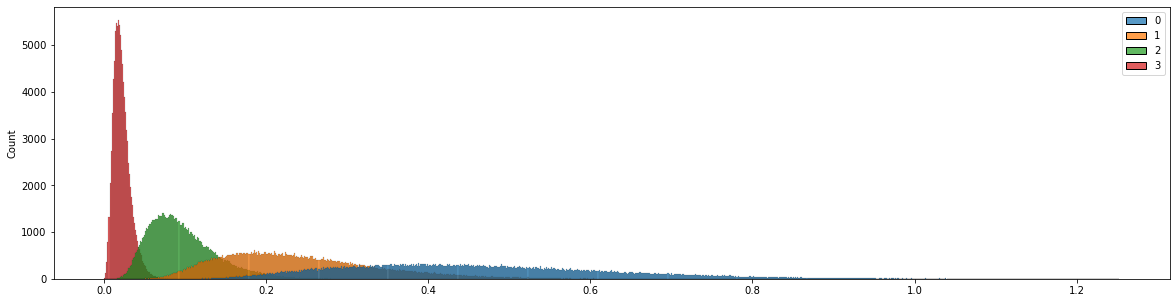

In [21]:
plt.figure(figsize=(20,5))
sns.histplot(ctxt_dist_results,bins=1000)
plt.savefig('figures/nback-hist-test2.svg',format='svg')

<function matplotlib.pyplot.savefig(*args, **kwargs)>

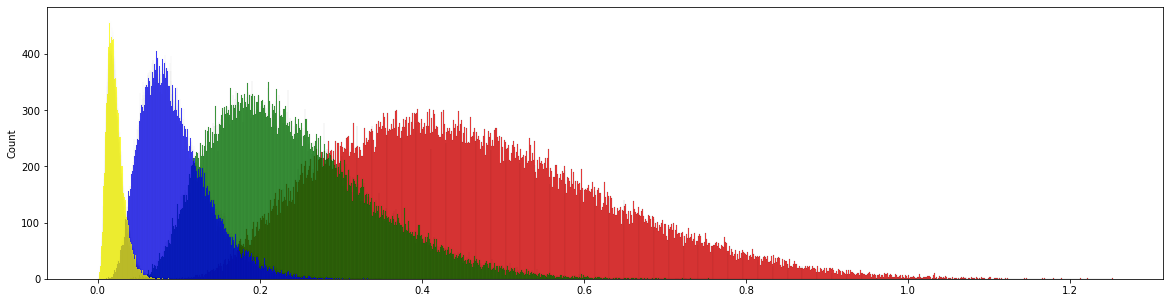

In [22]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.figure(figsize=(20,5))
ax = plt.gca()

L = ['r','g','b','yellow','orange']
for idx,ctxt_dist in enumerate(ctxt_dist_results.T):
  sns.histplot(ctxt_dist,bins=1000,ax=ax,color=L[idx])
plt.savefig('figures/nback-hist-test2.svg',format='svg')


In [23]:
plt.savefig?

In [ ]:
assert False

In [ ]:
def sim_nback_context(set_size,delta=1,
      nitr=1,metric='cosine',cvar=.1,cmean=.1,cdim=20,verb=False):  
  """
  - generate multiple draws from context sequence
  - calculate distance between reference context and
  - (i)  target context    (nback)
  - (ii) nontarget context (nback+-k)
  return array of distances (i) & (ii)
  """
  exp_size = 5
  current_t = exp_size - 1
  target_t = current_t - set_size
  nontarget_t = target_t+delta
  if verb: print('ss',set_size,'current_t',current_t,
            'target',target_t,'nontarget',nontarget_t)

  # loop vars
  dist2targetL = []
  dist2nontargetL = []
  for itr in range(nitr):
    # sample new context
    C = fast_n_sphere(n_steps=exp_size, dim=cdim, var=cvar, mean=cmean)[0]
    # target distance
    dist2target_, _= distance.cdist(
      [C[current_t,:]],[C[target_t,:]],
      metric=metric)
    # nontarget distance
    dist2nontarget_, _ = distance.cdist(
      [C[current_t,:]],[C[nontarget_t,:]],
      metric=metric)
    # collect
    dist2targetL.append(dist2target_)
    dist2nontargetL.append(dist2nontarget_)
    
  dist2target = np.concatenate(dist2targetL)
  dist2nontarget = np.concatenate(dist2nontargetL)
  return dist2target,dist2nontarget


In [ ]:
def plt_roc(ax,dist_target,dist_nontarget,label):
  """ confirm that this is an ROC
  assuming that distance is the signal for detecting "match"
  
  """
  lower = np.min([dist_target.min(),dist_nontarget.min()]) 
  upper = np.max([dist_target.max(),dist_nontarget.max()]) 
  hist_target,_ = np.histogram(dist_target,range=(lower,upper),bins=100)
  hist_nontarget,_ = np.histogram(dist_nontarget,range=(lower,upper),bins=100)
  ax.plot(
      np.cumsum(hist_target/hist_target.sum()),
      np.cumsum(hist_nontarget/hist_nontarget.sum()),
    label=label
  )
  ax.plot([0,1],[0,1],c='k',ls='--')
  return None

In [ ]:
def runexp_and_plt(M,N,K,ssL=[2,3],nitr=20000,sim_fn=sim_nback_context):
  """ 
  given parametrization of context
  runs experiments and generates histogram plots
  """
  f,axarr = plt.subplots(1,3,figsize=(20,6))
  scoreL = []
  for idx,ss in enumerate(ssL):
    ax = axarr[idx]
    ax.set_title('ss=%i',ss)
    # run simulations
    dist_target,dist_nontarget = sim_fn(
      set_size=ss,nitr=nitr,
      cvar=N,cmean=M,cdim=K
    ) 
    # plot histogtams
    hist_target = ax.hist(dist_target,bins=100)[0]
    hist_nontarget = ax.hist(dist_nontarget,bins=100)[0]
    # plot roc
    plt_roc(axarr[2],dist_target,dist_nontarget,"set-size=%i"%ss)
    ## calculate auc    
  plt.legend()
  fig_title = "K{}M{}N{}".format(K,M,N)
  plt.savefig('figures/nback/%s.png'%fig_title)
  plt.close('all')
  return None

### gridsearch and plt

In [ ]:
## gridsearch
ML = [0.2,0.3,0.4]
NL = [0.05,0.1,0.2,0.3]
KL = [5,10,20,25] 
for K,M,N in itertools.product(KL,ML,NL):
  print(K,M,N)
  runexp_and_plt(M,N,K,nitr=10000)
  print()

In [ ]:


# M,N = 0.2,0.2
# ax = plt.gca()
# for ss in [2,3,4]:
#   dist_target,dist_nontarget = sim_nback_context(ss,nitr=1000,cvar=N,cmean=M)
#   plt_roc(ax,dist_target,dist_nontarget,"set-size=%i"%ss)
# plt.legend()